In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ukb_gwas import *

In [6]:
snp = pd.read_csv('test_out.raw',delimiter = '\t')
snp.head(3)

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs4682039_G(/A)
0,5528770,5528770,0,0,0,-9,2.0
1,2112972,2112972,0,0,0,-9,0.0
2,2062810,2062810,0,0,0,-9,2.0


In [9]:
print(len(snp))
print(len(snp[snp['rs4682039_G(/A)']==0]))
print(len(snp[snp['rs4682039_G(/A)']==1]))
print(len(snp[snp['rs4682039_G(/A)']==2]))
print(53509 + 153565 + 109642)

329040
53509
153565
109642
316716


In [2]:
mover_betas = pd.read_csv('mover_betas.txt',delimiter=' ')
mover_betas.head(3)

,snp,ref,beta,se,count
0,rs1835339,C,-0.068965,0.018575,144625
1,rs10940921,G,0.065870,0.018713,137472
2,rs317050,C,-0.032541,0.017763,149602


In [3]:
stayer_betas = pd.read_csv('stayer_betas.txt',delimiter=' ')
stayer_betas.head(3)

,snp,ref,beta,se,count
0,rs7823700,C,0.058868,0.035803,131404
1,rs1835339,C,-0.036516,0.018663,144625
2,rs10940921,G,0.042874,0.018795,137472


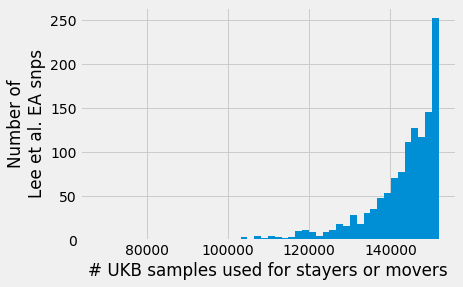

In [4]:
plt.style.use('fivethirtyeight')
plt.hist(mover_betas['count'],50)
plt.ylabel('Number of\nLee et al. EA snps')
plt.xlabel('# UKB samples used for stayers or movers')
# plt.yscale('log')
# plt.xlim([0,200000])
plt.show()

In [5]:
mover_snp_betas = dict(zip(mover_betas.snp,mover_betas.beta))
mover_snp_errors = dict(zip(mover_betas.snp,mover_betas.se))
mover_snp_refs = dict(zip(mover_betas.snp,mover_betas.ref))

stayer_snp_betas = dict(zip(stayer_betas.snp,stayer_betas.beta))
stayer_snp_errors = dict(zip(stayer_betas.snp,stayer_betas.se))
stayerr_snp_refs = dict(zip(stayer_betas.snp,stayer_betas.ref))

different_refs = []
same_refs = []
for snp in mover_snp_refs.keys():
    if mover_snp_refs[snp] != stayerr_snp_refs[snp]:
        different_refs.append(snp)
    else:
        same_refs.append(snp)
print(len(different_refs))
print(len(same_refs))

0
1252


In [6]:
snpsInBoth = list(set(stayer_snp_betas.keys())&set(mover_snp_betas.keys()))
print(len(snpsInBoth))

1252


In [7]:
snplist_betas_1 = [stayer_snp_betas[x] for x in snpsInBoth]
snplist_errors_1 = [stayer_snp_errors[x] for x in snpsInBoth]
snplist_betas_2 = [mover_snp_betas[x] for x in snpsInBoth]
snplist_errors_2 = [mover_snp_errors[x] for x in snpsInBoth]
print(len(snplist_errors_2))

1252


In [8]:
# magnitude ... do abs() unless signs opposite
# if sign switch .... make the larger one positive, and the smaller one negative

snplist_betas_1_magnitude = []
snplist_betas_2_magnitude = []

for i, sb1 in enumerate(snplist_betas_1):
    sb2 = snplist_betas_2[i]
    if (sb1 < 0 and sb2 < 0) or (sb1 >= 0 and sb2 >= 0):
        snplist_betas_1_magnitude.append(abs(sb1))
        snplist_betas_2_magnitude.append(abs(sb2))
        
    else: # if sign switch .... make the larger one positive, and the smaller one negative
        
        if abs(sb1) > abs(sb2):
            snplist_betas_1_magnitude.append(abs(sb1))
            snplist_betas_2_magnitude.append(-abs(sb2))
        else:
            snplist_betas_1_magnitude.append(-abs(sb1))
            snplist_betas_2_magnitude.append(abs(sb2))
print(len(snplist_betas_1_magnitude), len(snplist_betas_2_magnitude))

1252 1252


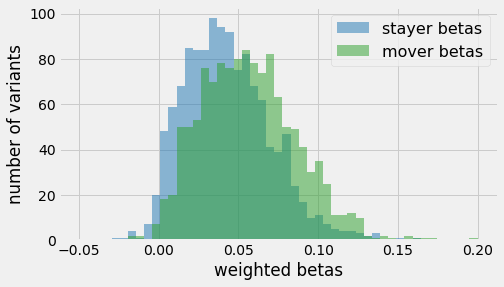

In [9]:
# let's look at those betas!
numBins = 50
plt.style.use('fivethirtyeight')
b1 = snplist_betas_1_magnitude
b2 = snplist_betas_2_magnitude

bins = np.linspace(-0.05, 0.2, numBins)

#f,(a1,a2) = plt.subplots(1,2,figsize = (14,4))
f,a2 = plt.subplots(1,1,figsize = (7,4))

# a1.hist(b1,bins,alpha = 0.5, label='stayers unrelated-5', color = 'blue')
# a1.hist(b2,bins,alpha = 0.5, label='movers unrelated-5', color = 'green')
# a1.legend(loc='upper right', fontsize=16)
# a1.set_ylabel('number of variants')
# #plt.yscale('log')
# a1.set_xlabel('betas')
#plt.suptitle('Eduyears: 1252 Lee snps, 40 PCs UKB')

j1,j2,wb1 = get_weighted_avg_beta(b1,snplist_errors_1)
j1,j2,wb2 = get_weighted_avg_beta(b2,snplist_errors_2)
a2.hist(wb1,bins,alpha = 0.5, label='stayer betas', color = 'tab:blue')
a2.hist(wb2,bins,alpha = 0.5, label='mover betas', color = 'tab:green')
a2.set_xlabel('weighted betas')
a2.set_ylabel('number of variants')
a2.legend(loc='upper right', fontsize=16)

plt.show()

In [10]:
zstat, eff1, eff2 = calc_z_statistic(wb1,wb2,
                         snplist_errors_1,snplist_errors_2,'stayers','movers')
p_values = stats.norm.sf(abs(zstat))*2
print('pval: ','{:1.1e}'.format(p_values))
print()
print('mover more: ', '{:1.1f}%'.format((eff2-eff1) * 100 / eff1))

diffs = (wb2-wb1)/wb1*100
print('\nPer snp diffs: ','{:1.1f}%'.format(np.mean(diffs)))

stayers:  avg_eff 0.0477  variance: 3.791e-07
movers:  avg_eff 0.0634  variance: 3.759e-07

difference in effect:  -0.0157

z-statistic:  -18.0695
pval:  5.5e-73

mover more:  32.9%

Per snp diffs:  102.2%


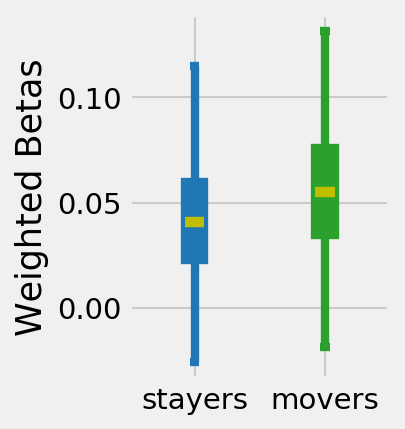

In [11]:
f,a = plt.subplots(1,1,figsize=(2,3),dpi=150)
bp = plt.boxplot(wb1, positions=[1], patch_artist=True, showfliers = False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
    plt.setp(bp[element], color='tab:blue' , linewidth = 4)
plt.setp(bp['medians'], color = 'y', linewidth = 5)

bp = plt.boxplot(wb2, positions=[2], patch_artist=True, showfliers = False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
    plt.setp(bp[element], color='tab:green', linewidth = 4)
plt.setp(bp['medians'], color = 'y', linewidth = 5)

plt.xticks([1,2],['stayers','movers'])
plt.ylabel('Weighted Betas')
plt.show()

In [12]:
# save for later
import pickle
fname = 'eduyears_genotypefreq_equalized.p'
pickle.dump([wb1,wb2],open(fname,'wb'))

stayers:  avg_eff -0.0028  variance: 3.791e-07
movers:  avg_eff -0.0020  variance: 3.759e-07

difference in effect:  -0.0008

z-statistic:  -0.9780
pval:  0.3280649041713656


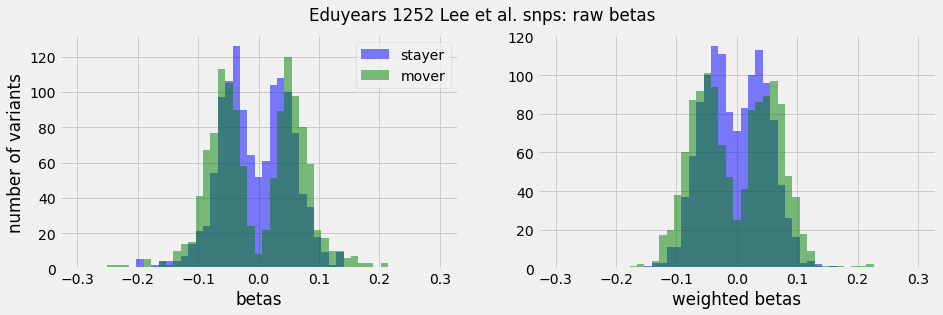

In [9]:
# let's look at those betas!
numBins = 50
plt.style.use('fivethirtyeight')
b1 = snplist_betas_1
b2 = snplist_betas_2

bins = np.linspace(-0.3, 0.3, numBins)

f,(a1,a2) = plt.subplots(1,2,figsize = (14,4))
a1.hist(b1,bins,alpha = 0.5, label='stayer', color = 'blue')
a1.hist(b2,bins,alpha = 0.5, label='mover', color = 'green')
a1.legend(loc='upper right')
a1.set_ylabel('number of variants')
#plt.yscale('log')
a1.set_xlabel('betas')

j1,j2,wb1 = get_weighted_avg_beta(b1,snplist_errors_1)
j1,j2,wb2 = get_weighted_avg_beta(b2,snplist_errors_2)
a2.hist(wb1,bins,alpha = 0.5, label='stayer\nweighted betas', color = 'blue')
a2.hist(wb2,bins,alpha = 0.5, label='mover\nweighted betas', color = 'green')
a2.set_xlabel('weighted betas')
plt.suptitle('Eduyears 1252 Lee et al. snps: raw betas')

zstat, eff1, eff2 = calc_z_statistic(b1,b2,
                         snplist_errors_1,snplist_errors_2,'stayers','movers')
p_values = stats.norm.sf(abs(zstat))*2
print('pval: ',p_values)

plt.show()